In [1]:
import pandas as pd
import pybasilica.run as run
import torch
import pyro
import pyro.distributions as dist
import numpy as np
import seaborn as sns
import sklearn.metrics
import torch.nn.functional as F
from tqdm import tqdm
from pyro.distributions import constraints

%load_ext autoreload
%autoreload 2

/Users/elenab/Library/r-miniconda-arm64/envs/basilica-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
m_g = pd.read_csv("test_datasets/counts_sbs.N150.G3.csv")
m_sbs = m_g.drop(["groups"], axis=1)
g_sbs = m_g["groups"].tolist() 
cosmic_sbs = pd.read_csv("test_datasets/COSMIC_filt.csv", index_col=0) 

In [3]:
m_g = pd.read_csv("test_datasets/counts_dbs.N150.G3.csv")
m_dbs = m_g.drop(["groups"], axis=1)
g_dbs = m_g["groups"].tolist()
cosmic_dbs = pd.read_csv("test_datasets/COSMIC_dbs.csv", index_col=0) 

In [4]:
obj_sbs = run.fit(
    x=m_sbs, 
    k_list=[3,4], 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=2000, 
    # cluster=[3],
    dirichlet_prior=True,
    beta_fixed=cosmic_sbs.loc[["SBS1","SBS3","SBS5"]], 
    store_parameters = True, 
    seed_list=[30],
    nonparametric=False,
    store_fits=True, enumer="parallel"
    )


ELBO 48017.537012: 100%|██████████| 2000/2000 [00:05<00:00, 340.42it/s]


In [5]:
obj_dbs = run.fit(
    x=m_dbs, 
    k_list=3, 
    lr=0.005, 
    optim_gamma=0.1,
    n_steps=1000, 
    # cluster=[3],
    dirichlet_prior=True,
    beta_fixed=cosmic_dbs.loc[["DBS3","DBS5"]], 
    store_parameters=False, 
    seed_list=[30],
    store_fits=True
    )


ELBO 132427.058856: 100%|██████████| 1000/1000 [00:03<00:00, 331.46it/s]


In [90]:
input_alpha = [obj_sbs.params["alpha"], obj_dbs.params["alpha"]]
obj_clust = run.fit(
    alpha=input_alpha,
    lr=0.001, 
    optim_gamma=0.1,
    n_steps=3000, 
    cluster=[3],
    store_parameters=False, 
    seed_list=[30],
    nonparametric=True,
    store_fits=True,
    enumer="parallel"
    )


tensor([[173.9120, 173.9120, 173.9120],
        [  5.0582,   5.0582,   5.0582]], dtype=torch.float64)


ELBO 25113.256788: 100%|██████████| 3000/3000 [00:07<00:00, 417.55it/s]


<Axes: >

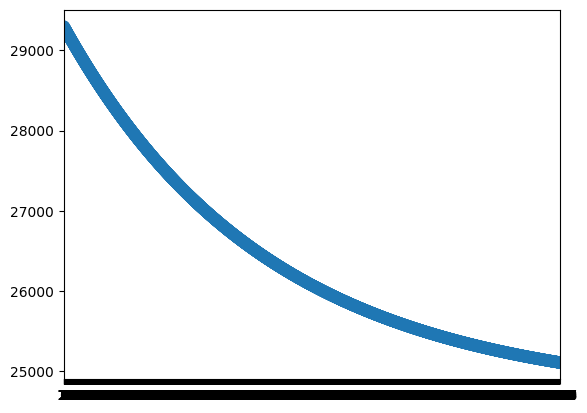

In [91]:
sns.pointplot(y=obj_clust.losses, x=np.arange(3000)) 

In [84]:
obj_clust.init_params["scale_factor_centroid"] 

array([[173.91197988, 173.91197988, 173.91197988],
       [  5.05816356,   5.05816356,   5.05816356]])

In [85]:
obj_clust.params["scale_factor_centroid"] 

array([[123.05549814, 127.39486583, 173.60682881],
       [  5.75006847,   5.22585883,   5.68975029]])

In [92]:
fitted_grps = obj_clust.groups 
init_grps = obj_clust.init_params["init_clusters"] 
sklearn.metrics.normalized_mutual_info_score(fitted_grps, init_grps) 

0.9303692509628704

In [ ]:
# print(obj_clust.init_params["alpha_prior"])
# print(obj_clust.params["alpha_prior"]) 

In [ ]:
print(obj_clust.init_params["pi"])
print(np.round(obj_clust.params["pi"], decimals=3)) 

In [ ]:
obj_clust.params["scale_factor_matrix"] 

In [ ]:
# sns.pointplot(y=obj_clust.gradient_norms["AutoDelta.beta_pi"],
#               x=np.arange(1000)) 
sns.pointplot(y=obj_clust.gradient_norms["AutoDelta.scale_factor_centroid"],
              x=np.arange(1000)) 
# sns.pointplot(y=obj_clust.gradient_norms["AutoDelta.latent_class"],
#               x=np.arange(1000)) 

In [ ]:
print(obj_clust.groups) 
print(obj_clust.init_params["init_clusters"]) 

In [ ]:
from scipy.optimize import fsolve, minimize_scalar

def _compute_dirichlet_variance(alpha):
    alpha_hat = np.sum(alpha)
    num = alpha * (alpha_hat - alpha)
    denomin = alpha_hat**2 * (alpha_hat + 1)
    return num / denomin

def variance_condition(C, target, alpha):
    variances = _compute_dirichlet_variance(alpha * C)
    # print(f"C={C}, max diff={max(np.abs(variances - target))}")
    return max(np.abs(variances - target))

# Initial guess for C
initial_C = 1
# Calculate the smallest C for the given alpha and Y
alpha = obj_clust.params["alpha_prior"].values[0, :7]
target = obj_clust.init_params["variances"].values[0, :7]

# Solve for C
C_solution = minimize_scalar(fun=variance_condition, method="Bounded", bounds=(1,500), args=(target, alpha))
C_solution.x

In [ ]:
from scipy.optimize import fsolve

def dirichlet_variance(alpha, alpha_hat):
    # alpha_hat = np.sum(alpha)
    num = alpha * (alpha_hat - alpha)
    denomin = alpha_hat**2 * (alpha_hat + 1)
    return num / denomin

def optim_fn(c, true_var, alpha, alpha_hat):
    variances = dirichlet_variance(alpha=alpha*c, alpha_hat=alpha_hat*c)
    return np.abs(true_var - variances) + 1.0


In [ ]:
alpha = dist.Dirichlet(torch.ones(5)).sample().numpy()
true_var = np.ones(5) * 1e-4 
print(f"alpha = {alpha}, true_var = {true_var}")
sols = fsolve(func=optim_fn, x0=1.0, args=(true_var[0], alpha[0], np.sum(alpha))) 

In [ ]:
def solver(target, alpha_hat, alpha_k):
    a = target*alpha_hat**3
    b = target*alpha_hat**2
    c = alpha_k**2 - alpha_k*alpha_hat

    d = np.sqrt(b**2 - 4*a*c)
    xs = np.array([(-b + d) / (2*a), (-b - d) / (2*a)])
    return np.amax(xs)

c = solver(target=true_var[0], alpha_hat=1, alpha_k=alpha[0])

In [ ]:
dirichlet_variance(alpha=alpha, alpha_hat=alpha.sum()) 